# NETS implementation

# 0. Set Up

For this tutorial, we will be using ``numpy`` to generate data and all operations, ``matplotlib`` to render and plot images and of course ``nets`` for ``Tensor`` operations and computational graph creation. We will set the ``SEED`` for random numbers from ``numpy``, so each time we reload the notebook the results will be the same as numbers will be generated in the same way. Finally, we set an autoreload with ``%load_ext autoreload`` and ``%autoreload 2`` for debug mode purposes. This enable the notebook to reload the modules each time we run a cell, so it keeps everything up-to-date. More info [on StackOverflow](http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython).

Let's load the packages we need to run our tests:

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')
# Change the font ?
font = {'size'   : 15}
plt.rc('font', **font)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
import sys

sys.path.append("../../")

In [6]:
# Let's fix the seed

SEED = 42
rd.seed(SEED)
np.random.seed(SEED)

# 1. Import the Dataset

In [7]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

import nets
import nets.datasets as datasets

# IMPORTANT: normalize the data !
reshape = lambda x: x.reshape(-1, 784)
normalize = lambda x: (x - np.mean(x, axis=1, keepdims=True)) / np.std(x, axis=1, keepdims=True)
transform = lambda x: normalize(reshape(x))

# Download the training and testing data
train_data, test_data = datasets.MNIST.splits(transform = transform)


# Let's check the CIFAR10 dataset structure
train_data

Dataset MNIST(
   (data): Tensor(shape=(60000, 784), dtype=float64)
   (labels): Tensor(shape=(60000,), dtype=uint8)
)

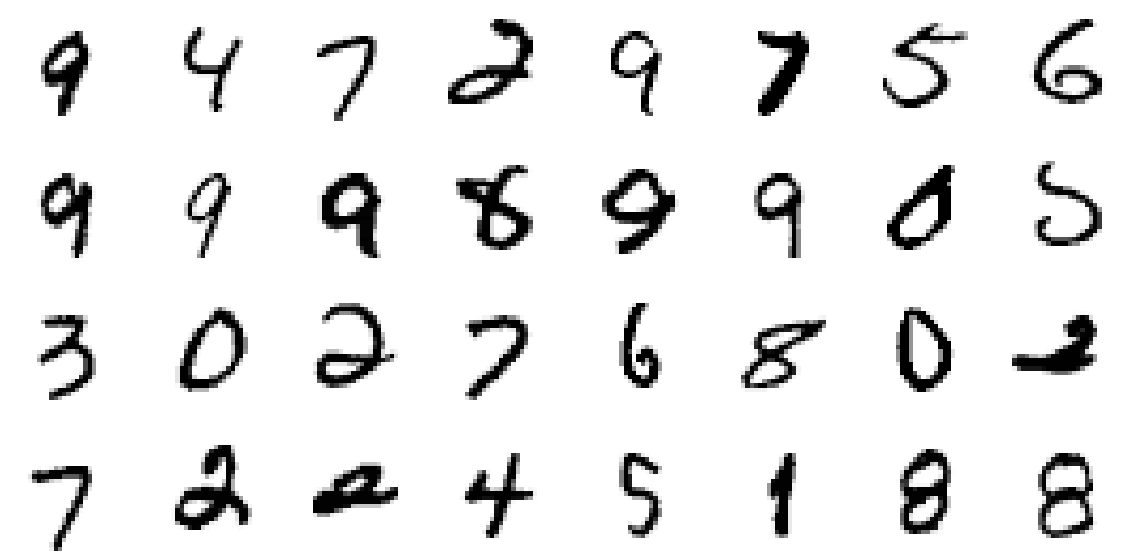

In [8]:
# CIFAR10 classes
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Configure the mosaic to display images
fig = plt.figure(figsize = (20, 10))
columns = 8
rows = 4

# Create the mosaic
for i in range(1, columns * rows + 1):
    # Choose randomly an image
    image_index = rd.randint(0, len(train_data))
    image, label = train_data[image_index]
    # Plot it
    fig.add_subplot(rows, columns, i)
    plt.imshow(image.data.reshape(28, 28))
    # Remove axis and display image's label
    # plt.title(classes[label.data])
    plt.axis('off')
    
# Render
plt.show()

# 2. Load the data

In [9]:
from nets.data import Iterator

BATCH_SIZE = 64

iterator = Iterator(train_data, 
                    batch_size = BATCH_SIZE, 
                    shuffle = True)

# 3. Build a model

In [10]:
import nets.nn as nn

# Just a simple model
class Classifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, inputs):
        out1 = nets.relu(self.layer1(inputs))
        out2 = nets.relu(self.layer2(out1))
        return self.layer3(out2)
    
model = Classifier(784, 100, 10)

# Let's check the architecture
model

Classifier(
   (layer1): Linear(input_dim=784, output_dim=100, bias=True)
   (layer2): Linear(input_dim=100, output_dim=100, bias=True)
   (layer3): Linear(input_dim=100, output_dim=10, bias=True)
)

# 4. Criterion & Optimizer

In [14]:
from nets.optim import SGD
from nets.nn import CrossEntropyLoss
from nets.nn.utils import one_hot

# How much do we update the parameters
LEARNING_RATE = 0.01

optimizer = SGD(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

# 5. Training

In [ ]:
import time
from nets.utils import progress_bar

# Training iterations
EPOCHS = 50

#Display the time during training
start = time.time()
# Record the loss
history = []

# Run the simulation EPOCHS times
for epoch in range(EPOCHS):
    
    # Keep track of the loss at each epoch
    epoch_loss = 0.0
    epoch_start = time.time()
    
    # Number of batches
    N  = len(iterator)

    # Predict for all batches
    for idx, batch in enumerate(iterator):
        
        # Gradients accumulates, therefore we need to set them to zero at each iteration
        model.zero_grad()
        
        # Get the data from the batch
        image, label = batch        
        # Run the forward pass on the model
        predictions = model(image)
        # Get how far are the predictions from the truth (aka gold labels)
        label = one_hot(label, 10).astype(int)
        loss = criterion(predictions, label)
        
        # Compute the gradient
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        # Record the loss for plotting
        epoch_loss += loss.item() 
        # .item() is really important, it will free the memory from the computational graph
        
        # Let's plot a progress bar in the console
        progress_bar(idx, N, "Training:")
    
    # Update the history of all previous loss
    history.append(epoch_loss / N)
    
    # Check the mean loss for this loop
    print(f"epoch: {epoch}/{EPOCHS} | loss: {epoch_loss / N:1.3E}")

# Duration of the total training loop
print('\ntime:', time.time() - start)

In [ ]:
plt.plot(history)
plt.title("Loss on MNIST dataset")
plt.xlabel("epochs")
plt.ylabel("loss")